In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import pickle
import glob
import datetime
from os import path
from matplotlib.tri import Triangulation
from scipy.stats import linregress

%matplotlib inline

In [2]:
def get_membership_integral(f,ext = 3.,N = 500):
    resg = 2. * ext / N
    with open(f,'rb') as fid:
        data = pickle.load(fid,encoding='latin-1')
    ctime = data['runtime']
    del data['runtime']
    xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
    rg = np.sqrt(xg**2. + yg**2.)
    tg = np.arctan2(xg,yg) * 180./np.pi
    tg[tg < -90.] += 360.
    z = np.zeros_like(xg) * np.nan
    for ind,n in enumerate(sorted(list(data.keys()))[::-1]):
        xy = data[n]['xy'][len(data[n]['xy']) - 1][:,0]
        r = np.sqrt(xy.real**2. + xy.imag**2.)
        theta = np.arctan2(xy.real,xy.imag) * 180./np.pi
        theta[theta < -90] += 360.
        #try:
        trif = Triangulation(r,theta).get_trifinder()
        for j in range(N):
            for i in range(N):
                if trif(rg[j,i],tg[j,i]) != -1:
                    z[j,i] = ind / (len(data) + 1)
        #except:
            #if len(r) == 1:
            #    d = np.sqrt((xg - xy.real)**2. + (yg - xy.imag)**2.)
            #    j,i = np.where(d == np.nanmin(d))
            #    z[j[0],i[0]] = ind / (len(data) + 1)
            #else:
            #print('Something unexpected happened with the triangulation for %s on level %.2f'%(f.split('/')[-1],ind))
            #return np.nan
    z = z * resg**2.
    
    return np.nansum(z),ctime

In [63]:
crisp_files1 = sorted(glob.glob('D:/rerun_sensitivity_202209/constant_results/*_npg1_npl1_fd10.pickle'))
crisp_files2 = sorted(glob.glob('D:/iCloudDrive/Thesis/rerun_sensitivity_202209/constant_results/*_npg1_npl1_fd10.pickle'))
crisp_files = crisp_files1 + crisp_files2
cskill = []
for f in crisp_files:
    attribs = f.split('\\')[-1].split('_')[1:]
    dt = float(attribs[0][2:])
    res = float(attribs[1][3:]) / 1000.
    if res == 0.2:
        continue
    with open(f,'rb') as fid:
        data = pickle.load(fid)
    f_xy = data[0.]['xy'][len(data[0.]['xy']) - 1][0,0]
    s = np.absolute(f_xy - np.complex(0.,1.))
    skill = np.max([0.,1. - s])
    cskill.append([dt,res,skill])
cskill = np.asarray(cskill)

C:\Users\hauke\AppData\Local\Temp/ipykernel_21748/2595296497.py:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  s = np.absolute(f_xy - np.complex(0.,1.))


[[1.50000000e+02 1.00000000e-01 9.86283896e-01]
 [1.80000000e+02 1.00000000e-01 9.86268341e-01]
 [2.70000000e+02 1.00000000e-01 9.86534578e-01]
 [3.60000000e+02 1.00000000e-01 9.86244332e-01]
 [1.00000000e+01 1.50000000e-01 3.86571567e-01]
 [1.00000000e+01 2.50000000e-02 9.72329634e-01]
 [1.20000000e+02 1.00000000e-01 9.92193254e-01]
 [1.20000000e+02 1.00000000e-02 9.99573978e-01]
 [1.20000000e+02 1.50000000e-01 9.65785437e-01]
 [1.20000000e+02 2.50000000e-02 9.95428110e-01]
 [1.20000000e+02 5.00000000e-02 9.83506913e-01]
 [1.50000000e+01 1.00000000e-01 9.80023243e-01]
 [1.50000000e+01 5.00000000e-02 9.97476528e-01]
 [2.00000000e+01 1.00000000e-01 9.95966181e-01]
 [2.00000000e+01 1.50000000e-01 7.65049788e-01]
 [2.00000000e+01 2.50000000e-02 9.74296440e-01]
 [2.00000000e+01 5.00000000e-02 9.96368166e-01]
 [2.50000000e+01 1.00000000e-01 7.32693565e-01]
 [2.50000000e+01 5.00000000e-02 7.57580155e-01]
 [3.00000000e+01 1.00000000e-01 9.93866297e-01]
 [3.00000000e+01 1.50000000e-01 9.872524

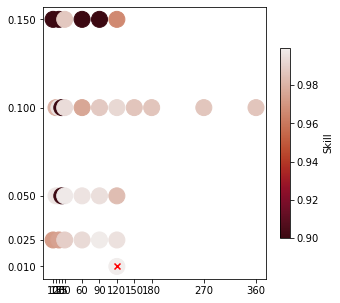

In [64]:
fig,ax = plt.subplots(figsize=(5,5))
pc = ax.scatter(cskill[:,0],cskill[:,1],c=cskill[:,2],cmap=cm.amp_r,s=256,vmin=0.9)
fig.colorbar(pc,orientation='vertical',shrink=0.7,label='Skill')
_=ax.set_xticks(np.unique(cskill[:,0]))
_=ax.set_yticks(np.unique(cskill[:,1]))
c = np.where(cskill[:,2] == np.nanmax(cskill[:,2]))[0][0]
ax.scatter(cskill[c,0],cskill[c,1],color='r',marker='x')
print(cskill)

In [46]:
files = sorted(glob.glob('D:/rerun_sensitivity_202209/constant_results/fuzzyTrial_*.pickle'))

params = []
for f in files:
    attribs = f.split('\\')[-1].split('_')[1:]
    dt = float(attribs[0][2:])
    res = float(attribs[1][3:]) / 1000.
    if res == 0.2:
        continue
    npg = int(attribs[2][3:])
    npl = int(attribs[3][3:])
    fd = float(attribs[4].split('.')[0][2:]) / 10.
    if fd == 1.:
        continue
    Iu,ctime = get_membership_integral(f)
    params.append([dt,res,npg,npl,fd,Iu,ctime])
    
fsave = './constant_params_lowerDT.pickle'

with open(fsave,'wb',-1) as fid:
    pickle.dump(params,fid)

In [47]:
with open('D:/iCloudDrive/Thesis/rerun_sensitivity_202209/constant_params.pickle','rb') as fid:
    params2 = pickle.load(fid)
    
params = np.vstack([params,params2])

In [65]:
params = np.asarray(params)
acskill = np.zeros([params.shape[0],])
for i in range(params.shape[0]):
    dt = params[i,0]
    res = params[i,1]
    c = np.where(np.logical_and(cskill[:,0] == dt,cskill[:,1] == res))[0]
    if len(c) > 0:
        acskill[i] = cskill[c[0],2]
    else:
        acskill[i] = np.nan

Text(0.5, 0, 'CFL #')

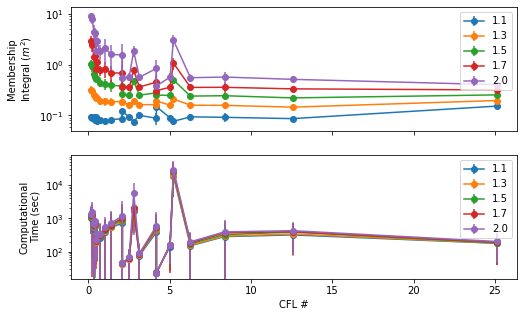

In [66]:
cfl = (2.*np.pi / params[:,0]) / params[:,1]

fig,axes = plt.subplots(2,1,sharex='col',figsize=(8,5))

for ind,ax in zip([5,6],axes):
    for fd in np.unique(params[:,4]):
        c = params[:,4] == fd
        cfls = np.unique(cfl[c])
        means = np.array([params[c,ind][cfl[c] == CFL].mean() for CFL in cfls])
        stdev = np.array([params[c,ind][cfl[c] == CFL].std() for CFL in cfls])
        ax.errorbar(cfls,means,yerr=stdev,label='%.1f'%fd,marker='o')

    ax.legend()
    ax.set_yscale('log')
    
axes[0].set_ylabel('Membership\nIntegral ($m^2$)')
axes[1].set_ylabel('Computational\nTime (sec)')
axes[1].set_xlabel('CFL #')

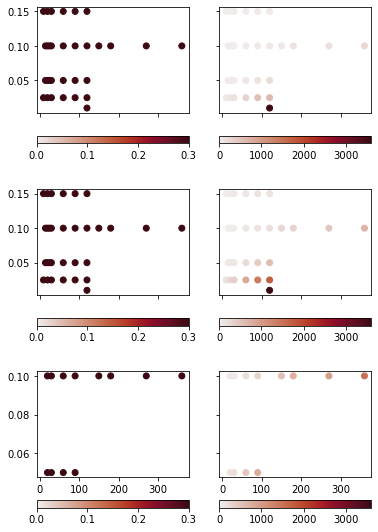

In [67]:
fig,axesarr = plt.subplots(3,2,sharex='col',sharey='row',figsize=(6,9.5))

#print(params[params[:,5] == params[:,5].max(),:])
#print(params[params[:,6] == params[:,6].min(),:])

fd = 1.5
npg = 16
c1 = np.where(params[:,4] == fd)[0]
c2 = np.where(params[:,2] == npg)[0]
for axI,npl in zip(range(axesarr.shape[0]),[5,7,9]):
    axes = axesarr[axI,:]
    c3 = np.where(params[:,3] == npl)[0]
    c = np.intersect1d(c1,np.intersect1d(c2,c3))
    for ind,ax,mima in zip([5,6],axes,[[0.,0.3],[0.,3600.]]):
        if ind == 5:
            colmap = 1. - params[c,ind] / params[:,ind].max()
        else:
            colmap = params[c,ind]
        pc = ax.scatter(params[c,0],params[c,1],c=colmap,cmap=cm.amp,vmin=mima[0],vmax=mima[1])
        plt.colorbar(pc,ax=ax,orientation='horizontal')

In [68]:
arr = params[:,5]
sorarr = arr[arr.argsort()][::-1]
print(sorarr[:10])
print(params[:,6][arr.argsort()][::-1][:10])
print(params[arr == sorarr[0],:])

[10.518624  10.2400992  9.7130304  9.5986944  9.1118016  8.6671296
  8.1073152  8.0787456  7.5835296  6.8752512]
[3297.5060489 1587.1344336  749.2675954 4676.2303185 1972.7473906
  495.6075124 1102.9219555 1116.4795349 1255.8369388 2891.5730089]
[[3.60000000e+02 1.00000000e-01 3.20000000e+01 7.00000000e+00
  2.00000000e+00 1.05186240e+01 3.29750605e+03]]


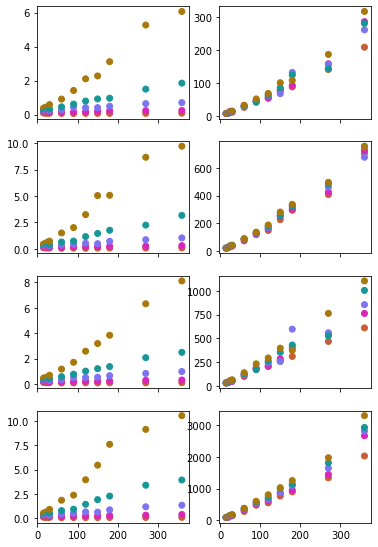

In [69]:
fig,axes = plt.subplots(4,2,sharex='col',figsize=(6,9.5))

for axI,npg,npl in zip(range(axes.shape[0]),[16.,16.,32.,32.],[5.,7.,5.,7.]):
    ax = axes[axI,:]
    c = np.where(np.logical_and(params[:,1] == 0.1,
                                np.logical_and(params[:,2] == npg,
                                               np.logical_and(params[:,3] == npl,params[:,4] > 0.))))[0]
    ax[0].scatter(params[c,0],params[c,5],c=params[c,4],cmap=cm.phase,vmin=1.,vmax=2.)
    ax[1].scatter(params[c,0],params[c,6],c=params[c,4],cmap=cm.phase,vmin=1.,vmax=2.)
    #ax[1].set_yscale('log')

In [53]:
dt = 270.
npg = 32.
npl = 9.

for fd in [1.1,1.3,1.5,1.7,2.]:
    c = np.where(np.logical_and(params[:,0] == dt,
                                np.logical_and(params[:,2] == npg,
                                               np.logical_and(params[:,3] == npl,params[:,4] == fd))))[0]
    res = params[c,1]
    fuzz = params[c,5]
    slo,inte,r,p,sloerr = linregress(res,fuzz)
    print(fd,slo,inte,r,p,sloerr)

1.1 nan nan 0.0 nan nan
1.3 nan nan 0.0 nan nan
1.5 nan nan 0.0 nan nan
1.7 nan nan 0.0 nan nan
2.0 nan nan 0.0 nan nan


C:\Users\hauke\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\hauke\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hauke\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [70]:
#cost = np.zeros([params.shape[0],])
Frat = np.zeros([params.shape[0],])
Trat = np.zeros([params.shape[0],])
for fd in [1.1,1.3,1.5,1.7,2.]:
    c = np.where(params[:,4] == fd)[0]
    Frat[c] = params[c,5] / params[c,5].max()
    Trat[c] = params[c,6] / params[c,6][params[c,5] == params[c,5].max()]
cost = acskill * (1. - Frat) * Trat
cost[Trat > 1.] = np.nan

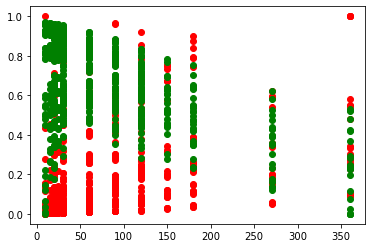

In [71]:
plt.scatter(params[Trat <= 1.,0],Trat[Trat <= 1.],color='r')
plt.scatter(params[Trat <= 1.,0],1. - Frat[Trat <= 1.],color='g')

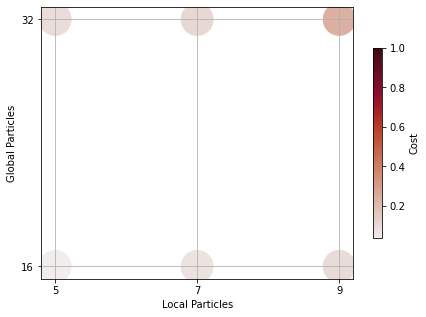

In [72]:
NPG = np.unique(params[:,2])
NPL = np.unique(params[:,3])
particle_grid = np.zeros([len(NPG),len(NPL)])
for j,npg in enumerate(NPG):
    for i,npl in enumerate(NPL):
        c = np.where(np.logical_and(params[:,2] == npg,params[:,3] == npl))[0]
        particle_grid[j,i] = np.nanmean(cost[c])
        
x,y = np.meshgrid(NPL,NPG)
fig,ax = plt.subplots(figsize=(7,5))
pc = ax.scatter(x,y,c=particle_grid,cmap=cm.amp,marker='o',s=1024,vmax=1.)
plt.colorbar(pc,orientation='vertical',shrink=0.7,label='Cost')
ax.set_xticks([t for t in NPL])
ax.set_yticks([t for t in NPG])
ax.set_xlabel('Local Particles')
ax.set_ylabel('Global Particles')
ax.grid(which='both')

C:\Users\hauke\AppData\Local\Temp/ipykernel_21748/114816575.py:7: RuntimeWarning: Mean of empty slice
  res_grid[j,i] = np.nanmean(cost[c])


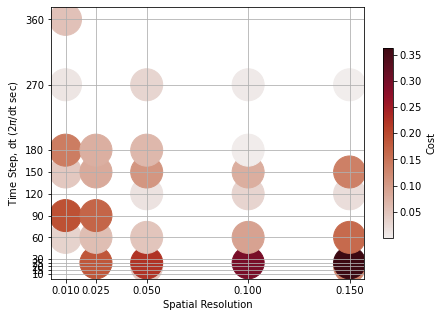

In [73]:
DT = np.unique(params[:,0])
RES = np.unique(params[:,1])
res_grid = np.zeros([len(RES),len(DT)])
for j,res in enumerate(RES):
    for i,dt in enumerate(DT):
        c = np.where(np.logical_and(params[:,0] == dt,params[:,1] == res))[0]
        res_grid[j,i] = np.nanmean(cost[c])
        
x,y = np.meshgrid(RES,DT)
fig,ax = plt.subplots(figsize=(7,5))
pc = ax.scatter(x,y,c=res_grid,cmap=cm.amp,marker='o',s=1024)#,vmax=3.)
plt.colorbar(pc,orientation='vertical',shrink=0.7,label='Cost')
ax.set_xticks([t for t in RES])
ax.set_yticks([t for t in DT])
ax.set_ylabel(r'Time Step, dt (2$\pi$/dt sec)')
ax.set_xlabel('Spatial Resolution')
ax.grid(which='both')

[0.01  0.025 0.05  0.1   0.15 ]


C:\Users\hauke\AppData\Local\Temp/ipykernel_21748/3172255135.py:17: RuntimeWarning: Mean of empty slice
  res_grid[j,i] = np.nanmean(cost[c])


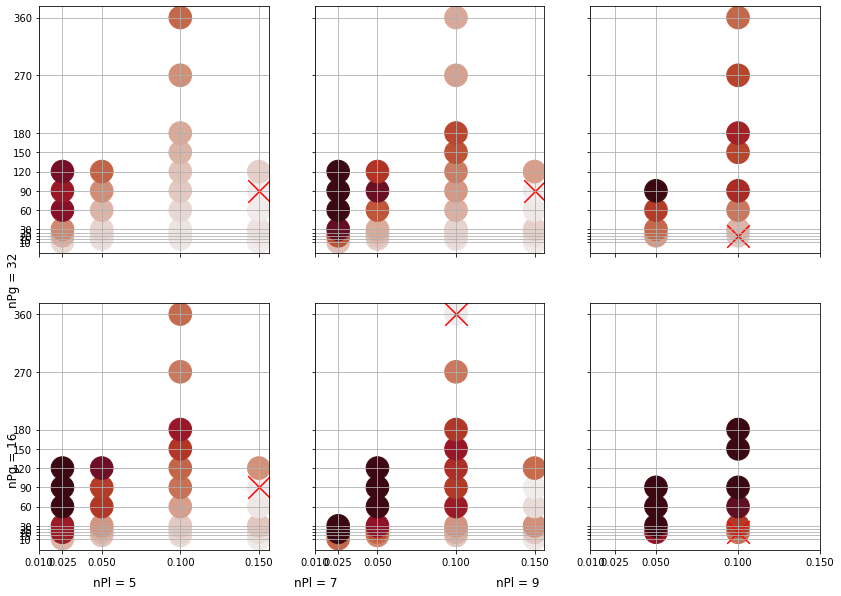

In [74]:
DT = np.unique(params[:,0])
RES = np.unique(params[:,1])
print(RES)
NPG = np.unique(params[:,2])
NPL = np.unique(params[:,3])
fig,axes = plt.subplots(len(NPG),len(NPL),sharex = 'col',sharey = 'row',figsize=(14,10))

for aj,npg in enumerate(NPG):
    for ai,npl in enumerate(NPL):
        ax = axes[aj,ai]
        x,y = np.meshgrid(RES,DT)
        res_grid = np.zeros_like(x)
        for i,res in enumerate(RES):
            for j,dt in enumerate(DT):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                           np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                res_grid[j,i] = np.nanmean(cost[c])

        pc = ax.scatter(x,y,c=res_grid,cmap=cm.amp,vmin=0.,vmax=0.2,marker='o',s=512)
        jm,im = np.where(res_grid == np.nanmin(res_grid))
        ax.scatter(x[jm,im],y[jm,im],c='r',marker='x',s=512)
        ax.set_xticks([t for t in RES])
        ax.set_yticks([t for t in DT])
        #ax.set_ylabel(r'Time Step, dt (2$\pi$/dt sec)')
        #ax.set_xlabel('Spatial Resolution')
        ax.grid(which='both')
        
for xl,npl in zip([0.2,0.4,0.6,0.8],NPL):
    fig.text(xl,0.08,'nPl = %1i'%npl,ha='center',va='center',fontsize=12)
    
for yl,npg in zip([0.25,0.5,0.75],NPG):
    fig.text(0.1,yl,'nPg = %1i'%npg,ha='center',va='center',fontsize=12,rotation=90.)

In [75]:
from mpl_toolkits.mplot3d import Axes3D

[9.00000000e+01 1.00000000e-01 3.20000000e+01 9.00000000e+00
 2.00000000e+00 3.11434560e+00 1.42719933e+03]


C:\Users\hauke\AppData\Local\Temp/ipykernel_21748/904376292.py:9: RuntimeWarning: Mean of empty slice
  fd_avg_cost[c] = np.nanmean(cost[c])
C:\Users\hauke\AppData\Local\Temp/ipykernel_21748/904376292.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.scatter(Cg,params[:,3],z,s=0.1/fd_avg_cost,color='k',alpha=0.2,zorder=1000)


Text(0.5, 0, 'log2(nPg)')

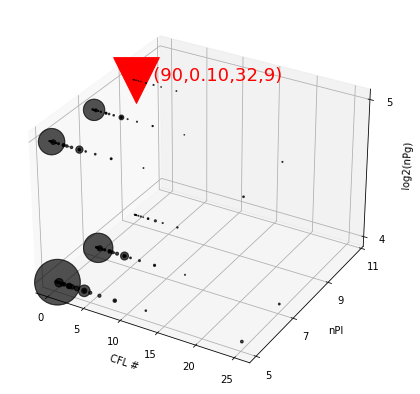

In [76]:
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(cost[c])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
ax.scatter(Cg,params[:,3],z,s=0.1/fd_avg_cost,color='k',alpha=0.2,zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmin(fd_avg_cost[fd_avg_cost !=0.]))[0][-1]
print(params[ccm,:])
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=0.1/np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,6.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')

In [13]:
f = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/constant_results/fuzzyTrial_dt15_res100_npg16_npl5_fd13.pickle'

with open(f,'rb') as fid:
    data = pickle.load(fid)
    print(data['runtime'])

8.2709961999999


In [14]:
cskill[np.logical_and(cskill[:,0] == 15.,cskill[:,1] == 0.1),2]

array([0.98002324])

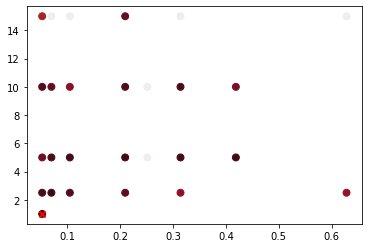

In [50]:
crisp_cfl = (2.*np.pi / cskill[:,0]) / cskill[:,1]
plt.scatter(2.*np.pi / cskill[:,0],cskill[:,1]*100.,c=cskill[:,2] - cskill[:,2].max(),cmap=cm.amp,vmin=-0.1,vmax=0.,s=48)
plt.scatter(2.*np.pi / cskill[cskill[:,2] == cskill[:,2].max(),0],
            cskill[cskill[:,2] == cskill[:,2].max(),1]*100.,marker='x',lw=2,color='r')

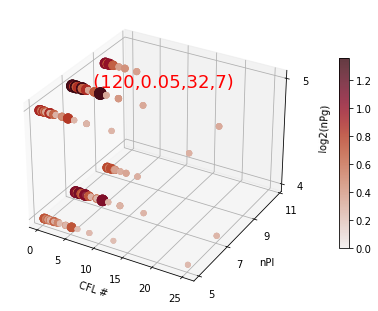

In [16]:
#fuzziness as function of parameter space
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(params[c,5])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
sc = ax.scatter(Cg,params[:,3],z,s=10**2.*fd_avg_cost,c=fd_avg_cost,cmap=cm.amp,alpha=0.8,vmin=0.,vmax=fd_avg_cost.max(),zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmax(fd_avg_cost[fd_avg_cost !=0.]))[0][0]
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=1./np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,6.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')
plt.colorbar(sc,pad=0.1,shrink=0.5)

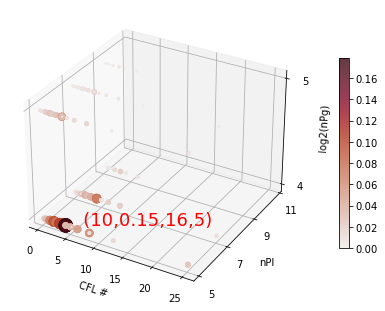

In [17]:
#computational time as a function of parameter space
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(params[c,6])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
sc = ax.scatter(Cg,params[:,3],z,s=10**3./fd_avg_cost,c=1./fd_avg_cost,cmap=cm.amp,alpha=0.8,vmin=0.,vmax=1./fd_avg_cost.min(),zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmin(fd_avg_cost[fd_avg_cost !=0.]))[0][0]
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=1./np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,6.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')
plt.colorbar(sc,pad=0.1,shrink=0.5)